# Sampling

## Load the Model

In [27]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

checkpoint_path = "24022025.pth"
checkpoint = torch.load(checkpoint_path)

dim = 2
num_rays_per_point = 6
cond_dim = 2 + num_rays_per_point + 1
layers_count = 6

class ActNorm(nn.Module):
    def __init__(self, dim, init=True):
        super().__init__()
        self.dim = dim
        self.initialized = (not init)
        self.bias = nn.Parameter(torch.zeros(dim))
        self.log_scale = nn.Parameter(torch.zeros(dim))
    def initialize_params(self, x):
        with torch.no_grad():
            mean = x.mean(dim=0)
            std = x.std(dim=0)
            self.bias.data = -mean
            self.log_scale.data = torch.log(1.0 / (std + 1e-6))
        self.initialized = True
    def forward(self, x, cond=None):
        if not self.initialized:
            self.initialize_params(x)
        y = (x + self.bias) * torch.exp(self.log_scale)
        log_det = self.log_scale.sum().expand_as(x[:, 0])
        return y, log_det
    def inverse(self, y, cond=None):
        x = y * torch.exp(-self.log_scale) - self.bias
        log_det = -self.log_scale.sum().expand_as(y[:, 0])
        return x, log_det

class Invertible1x1Conv(nn.Module):
    def __init__(self, dim):
        super().__init__()
        w_init = torch.qr(torch.randn(dim, dim))[0]
        self.weight = nn.Parameter(w_init)
        self.dim = dim
    def forward(self, x, cond=None):
        y = x @ self.weight
        log_det = torch.logdet(self.weight).expand_as(x[:, 0])
        return y, log_det
    def inverse(self, y, cond=None):
        W_inv = torch.inverse(self.weight)
        x = y @ W_inv
        log_det = -torch.logdet(self.weight).expand_as(y[:, 0])
        return x, log_det

class AffineCouplingGLOW(nn.Module):
    def __init__(self, dim, cond_dim):
        super().__init__()
        self.dim = dim
        self.half_dim = dim // 2
        self.cond_dim = cond_dim
        self.net = nn.Sequential(
            nn.Linear(self.half_dim + cond_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, self.half_dim * 2),
        )
    def forward(self, x, cond):
        x1 = x[:, :self.half_dim]
        x2 = x[:, self.half_dim:]
        input_net = torch.cat([x1, cond], dim=1)
        s_t = self.net(input_net)
        scale, shift = s_t.chunk(2, dim=1)
        scale = torch.tanh(scale)
        y2 = x2 * torch.exp(scale) + shift
        y = torch.cat([x1, y2], dim=1)
        log_det = scale.sum(dim=1)
        return y, log_det
    def inverse(self, y, cond):
        y1 = y[:, :self.half_dim]
        y2 = y[:, self.half_dim:]
        input_net = torch.cat([y1, cond], dim=1)
        s_t = self.net(input_net)
        scale, shift = s_t.chunk(2, dim=1)
        scale = torch.tanh(scale)
        x2 = (y2 - shift) * torch.exp(-scale)
        x = torch.cat([y1, x2], dim=1)
        log_det = -scale.sum(dim=1)
        return x, log_det

class GLOWStep(nn.Module):
    def __init__(self, dim, cond_dim):
        super().__init__()
        self.actnorm = ActNorm(dim)
        self.inv_conv = Invertible1x1Conv(dim)
        self.coupling = AffineCouplingGLOW(dim, cond_dim)
    def forward(self, x, cond):
        x, ldj_act = self.actnorm(x)
        x, ldj_conv = self.inv_conv(x)
        x, ldj_coup = self.coupling(x, cond)
        ldj = ldj_act + ldj_conv + ldj_coup
        return x, ldj
    def inverse(self, y, cond):
        x, ldj_coup = self.coupling.inverse(y, cond)
        x, ldj_conv = self.inv_conv.inverse(x)
        x, ldj_act = self.actnorm.inverse(x)
        ldj = ldj_act + ldj_conv + ldj_coup
        return x, ldj

class NormalizingFlow(nn.Module):
    def __init__(self, steps):
        super().__init__()
        self.steps = nn.ModuleList(steps)
    def forward(self, x, cond):
        total_ldj = 0
        for step in self.steps:
            x, ldj = step.forward(x, cond)
            total_ldj += ldj
        return x, total_ldj
    def inverse(self, z, cond):
        total_ldj = 0
        for step in reversed(self.steps):
            z, ldj = step.inverse(z, cond)
            total_ldj += ldj
        return z, total_ldj

class BaseDistribution(nn.Module):
    def __init__(self, mean=torch.tensor([0.0, 0.0]), std=torch.tensor([1.0, 1.0])):
        super().__init__()
        self.dist = torch.distributions.MultivariateNormal(
            loc=mean, covariance_matrix=torch.diag(std**2)
        )
    def sample(self, num_samples):
        return self.dist.sample((num_samples,))
    def log_prob(self, x):
        return self.dist.log_prob(x)

class FlowModel(nn.Module):
    def __init__(self, flow, base_dist):
        super().__init__()
        self.flow = flow
        self.base_dist = base_dist
    def forward(self, x, cond):
        z, log_det_jacobian = self.flow.forward(x, cond)
        log_prob = self.base_dist.log_prob(z) + log_det_jacobian
        return log_prob
    def sample(self, num_samples, cond):
        z = self.base_dist.sample(num_samples)
        x, _ = self.flow.inverse(z, cond)
        return x

flow_steps = [GLOWStep(dim, cond_dim) for _ in range(layers_count)]
flow = NormalizingFlow(flow_steps)
base_dist = BaseDistribution()
model = FlowModel(flow, base_dist)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

data_x_mean = checkpoint['data_x_mean']
data_x_std  = checkpoint['data_x_std']
data_c_mean = checkpoint['data_c_mean']
data_c_std  = checkpoint['data_c_std']


## Functions for Sampling

In [139]:

def sample_points_inside_bubble(bubble_data, num_points):
    indices = np.argwhere(bubble_data > 0)
    if indices.size == 0:
        return np.empty((0, 2))
    chosen_indices = indices[np.random.choice(len(indices), size=num_points, replace=True)]
    offsets = np.random.rand(num_points, 2)
    return chosen_indices + offsets

def compute_ray_lengths(bubble_data, num_rays, start_point):
    from scipy.ndimage import gaussian_filter
    from scipy.interpolate import RegularGridInterpolator
    nx, ny = bubble_data.shape
    sigma = 1
    smoothed_bubble = gaussian_filter(bubble_data, sigma=sigma)
    contour_level = 0.3 * np.max(smoothed_bubble)
    interp_func = RegularGridInterpolator((np.arange(nx), np.arange(ny)), smoothed_bubble, bounds_error=False, fill_value=0)
    angles = np.deg2rad(np.linspace(0, 360, num_rays, endpoint=False))
    distances = []
    max_distance = np.hypot(nx, ny)
    sx, sy = start_point
    for angle in angles:
        ray_dx = np.cos(angle)
        ray_dy = np.sin(angle)
        distances_along_ray = np.linspace(0, max_distance, 1000)
        intersection_found = False
        for dist_ in distances_along_ray:
            x_ = sx + dist_ * ray_dx
            y_ = sy + dist_ * ray_dy
            if 0 <= x_ < nx and 0 <= y_ < ny:
                val = interp_func((x_, y_))
                if val <= contour_level:
                    distances.append(dist_)
                    intersection_found = True
                    break
            else:
                break
        if not intersection_found:
            distances.append(max_distance)
    return np.array(distances)

def sample_density_grid(num_samples, density_grid):
    total_density = density_grid.sum()
    if total_density <= 0:
        return np.array([]), np.array([])
    prob_grid = density_grid / total_density
    prob_flat = prob_grid.ravel()
    prob_flat = np.nan_to_num(prob_flat, nan=0.0)
    prob_flat /= prob_flat.sum()
    cell_indices = np.arange(prob_flat.size)
    chosen = np.random.choice(cell_indices, size=num_samples, p=prob_flat)
    rows, cols = np.unravel_index(chosen, density_grid.shape)
    x_offsets = np.random.rand(num_samples)
    y_offsets = np.random.rand(num_samples)
    x_coords = cols + x_offsets
    y_coords = rows + y_offsets
    return x_coords, y_coords

def sample_gt_in_bubble(num_samples, density_grid, bubble_data):
    final = []
    while len(final) < num_samples:
        x_samp, y_samp = sample_density_grid(2*num_samples, density_grid)
        for (xx, yy) in zip(x_samp, y_samp):
            ix, iy = int(np.floor(xx)), int(np.floor(yy))
            if (0 <= ix < bubble_data.shape[1]) and (0 <= iy < bubble_data.shape[0]):
                if bubble_data[iy, ix] > 0:
                    final.append((xx, yy))
            if len(final) >= num_samples:
                break
    return np.array(final[:num_samples])

def sample_from_flow_inside_bubble(model, cond_array, data_x_mean, data_x_std, bubble_data, n_samples=100):
    model.eval()
    per_cond = max(1, n_samples // cond_array.shape[0])
    cond_expanded = np.repeat(cond_array, repeats=per_cond, axis=0)
    cond_tensor = torch.tensor(cond_expanded, dtype=torch.float32)
    z = model.base_dist.sample(len(cond_tensor))
    with torch.no_grad():
        x_out, _ = model.flow.inverse(z, cond_tensor)
    x_out = x_out.cpu().numpy()
    x_out_denorm = x_out * data_x_std + data_x_mean
    inside_samples = []
    for pt in x_out_denorm:
        x, y = pt
        ix, iy = int(np.floor(x)), int(np.floor(y))
        if True or (0 <= ix < bubble_data.shape[1] and 0 <= iy < bubble_data.shape[0]):
            if bubble_data[iy, ix] > 0:
                inside_samples.append(pt)
        if len(inside_samples) >= n_samples:
            break
    return np.array(inside_samples[:n_samples])

def sample_for_single_bubble(
    density_path, 
    bubble_path, 
    model,
    data_x_mean, data_x_std, 
    data_c_mean, data_c_std,
    num_condition_points=24, 
    n_samples=100,
):

    density_grid = np.load(density_path)
    bubble_data  = np.load(bubble_path)
    log_mass = np.log(density_grid.sum() + 1e-8)

    pts_in_bubble = sample_points_inside_bubble(bubble_data, num_condition_points)
    if len(pts_in_bubble) == 0:
        print("No valid bubble points found.")
        return

    cond_rows = []
    for pt in pts_in_bubble:
        ray_lengths = compute_ray_lengths(bubble_data, num_rays_per_point, pt)
        norm = np.linalg.norm(ray_lengths)
        if (norm == 0) or np.isnan(norm):
            continue
        ray_lengths_norm = ray_lengths / norm
        c_raw = np.concatenate([pt, ray_lengths_norm, [log_mass]])
        cond_rows.append(c_raw)

    if len(cond_rows) < 1:
        print("All bubble points ended up invalid. No rays could be computed.")
        return

    c_array = np.stack(cond_rows, axis=0)
    c_std = (c_array - data_c_mean) / data_c_std

    x_samples_denorm = sample_from_flow_inside_bubble(
        model=model,
        cond_array=c_std,
        data_x_mean=data_x_mean,
        data_x_std=data_x_std,
        bubble_data=bubble_data,
        n_samples=n_samples
    )

    gt_points = sample_gt_in_bubble(n_samples, density_grid, bubble_data)

    return x_samples_denorm, gt_points, bubble_data, density_grid


def plot_points(x_samples_denorm, gt_points, bubble_data, title="Flow vs. GT-Sampling"):
    plt.figure(figsize=(6,6))
    plt.scatter(gt_points[:, 0], gt_points[:, 1], alpha=0.3, label="Ground Truth", marker='.')
    plt.scatter(x_samples_denorm[:, 0], x_samples_denorm[:, 1], alpha=0.7, label="Flow Samples", marker='.')
    plt.contour(bubble_data, levels=[0.5], colors='red', linewidths=1)
    plt.title(title)
    plt.xlabel("X [pixels]")
    plt.ylabel("Y [pixels]")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_density_map(points, bubble_data, bins=64, cmap="viridis", title=f"Flow Samples Density Map"):
    if len(points) == 0:
        print("No points provided for density plot.")
        return
    heatmap, xedges, yedges = np.histogram2d(points[:, 0], points[:, 1], bins=bins, range=[[0, 64], [0, 64]])
    heatmap = heatmap.T  # transpose for correct orientation

    plt.figure(figsize=(6, 5))
    plt.imshow(heatmap, origin='lower', cmap=cmap, extent=[0, 64, 0, 64])
    plt.contour(bubble_data, levels=[0.5], colors='red', linewidths=1)
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

def plot_density_comparison(gt_points, model_points, bubble_data, bins=64, cmap="viridis", truemass=1):
    if len(gt_points) == 0 or len(model_points) == 0:
        print("One of the point sets is empty.")
        return
    truemass = truemass/1e11
    extent = [0, 50, 0, 50]  # in Mpc/h

    fig, axs = plt.subplots(1, 2, figsize=(11, 5), constrained_layout=True)

    # GT
    heatmap_gt, _, _ = np.histogram2d(gt_points[:, 0], gt_points[:, 1], bins=bins, range=[[0, 64], [0, 64]])
    im0 = axs[0].imshow(heatmap_gt.T*truemass/np.sum(heatmap_gt), origin='lower', cmap=cmap, extent=extent, aspect='auto')
    axs[0].contour(bubble_data, levels=[0.5], colors='red', linewidths=1, extent=extent)
    axs[0].set_title("Ground Truth Density")
    axs[0].set_xlabel("X (Mpc/h)")
    axs[0].set_ylabel("Y (Mpc/h)")

    # Flow
    heatmap_model, _, _ = np.histogram2d(model_points[:, 0], model_points[:, 1], bins=bins, range=[[0, 64], [0, 64]])
    im1 = axs[1].imshow(heatmap_model.T*truemass/np.sum(heatmap_model), origin='lower', cmap=cmap, extent=extent, aspect='auto')
    axs[1].contour(bubble_data, levels=[0.5], colors='red', linewidths=1, extent=extent)
    axs[1].set_title("Model Sampled Density")
    axs[1].set_xlabel("X (Mpc/h)")
    axs[1].set_ylabel("Y (Mpc/h)")

    # shared colorbar
    cbar = fig.colorbar(im1, ax=axs, orientation='vertical', fraction=0.025, pad=0.02)
    cbar.set_label(r"Mass Density ($\times 10^{11}$ M$_\odot$)")



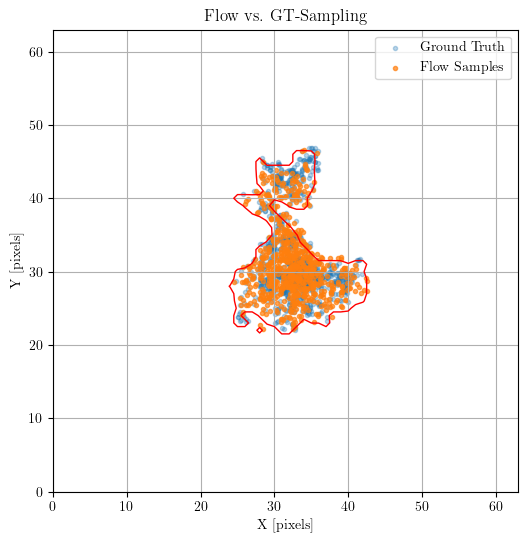

In [189]:

slice_test  = 100
bubble_test = 2

flow_samples, gt_samples, bubble_data, density_data = sample_for_single_bubble(
    density_path=f"mock_data/halo_density_patches/slice_{slice_test}_bubble_{bubble_test}_halo_density_filtered.npy",
    bubble_path=f"mock_data/isolated_bubbles/slice_{slice_test}_bubble_{bubble_test}_isolated.npy",
    model=model,
    data_x_mean=data_x_mean,
    data_x_std=data_x_std,
    data_c_mean=data_c_mean,
    data_c_std=data_c_std,
    num_condition_points=24,
    n_samples=1000
)

plot_points(flow_samples, gt_samples, bubble_data, title=f"Flow vs. GT-Sampling")


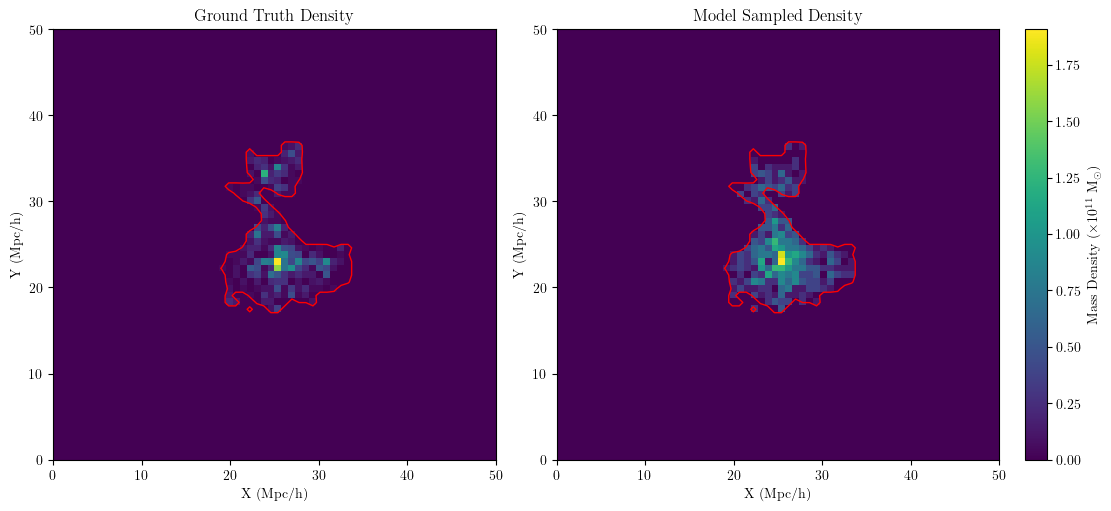

In [193]:
plot_density_comparison(gt_samples, flow_samples, bubble_data, truemass=np.sum(density_data))
plt.savefig(f"plots/density_sample_bubble_2.png", bbox_inches='tight', dpi=500)